# Airbnb Price Prediction

## Loading & Preparing

In [184]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# Text processing and visualization
from wordcloud import WordCloud

# Scikit-learn: Pipelines and transformers
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression

# Scikit-learn: Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Model selection and splitting
from sklearn.model_selection import train_test_split, GroupKFold, GroupShuffleSplit, GridSearchCV, StratifiedKFold, KFold
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

# Scikit-learn: Metrics
from sklearn.metrics import r2_score, mean_squared_error

# Scikit-learn: Models
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.inspection import permutation_importance
import shap
import warnings

# XGBoost
from xgboost import XGBRegressor

# Geospatial analysis
import folium

from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


In [185]:
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing')

In [186]:
data = pd.read_csv("listings.csv")
data.shape[0]

44684

In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44684 entries, 0 to 44683
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            44684 non-null  int64  
 1   listing_url                                   44684 non-null  object 
 2   scrape_id                                     44684 non-null  int64  
 3   last_scraped                                  44684 non-null  object 
 4   source                                        44684 non-null  object 
 5   name                                          44683 non-null  object 
 6   description                                   43349 non-null  object 
 7   neighborhood_overview                         23839 non-null  object 
 8   picture_url                                   44684 non-null  object 
 9   host_id                                       44684 non-null 

## Preprocessing

#### Seperating Columns

In [188]:
non_essential_features = [
    "id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_id", 
    "host_url", "host_thumbnail_url", "host_picture_url", "license", "calendar_updated", 
    "calendar_last_scraped", "host_listings_count", "host_location", 
    "neighbourhood", "host_neighbourhood", "neighbourhood_group_cleansed",
    "bathrooms_text", "maximum_minimum_nights", "maximum_maximum_nights", 
    "minimum_nights_avg_ntm", "minimum_maximum_nights", "maximum_nights_avg_ntm", "calculated_host_listings_count", 
    "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", 
    "calculated_host_listings_count_shared_rooms", "number_of_reviews_ltm", "reviews_per_month", 
    "number_of_reviews_l30d", "host_acceptance_rate", "name", "description", "neighborhood_overview", 
    "host_name", "host_about", "host_has_profile_pic", "host_total_listings_count", "host_identity_verified", "bedrooms"
]

continuous_features_std = [
    "number_of_reviews", "first_review", "last_review", "host_since"
] 

continuous_features_minmax = [
    "accommodates", "bathrooms", "beds", "availability_30", "availability_60", 
    "availability_90", "availability_365", "review_scores_accuracy", "review_scores_cleanliness", 
    "review_scores_checkin", "review_scores_communication", "review_scores_value", 
    "review_scores_rating", "review_scores_location", "host_response_rate"
]

categorical_features = [
    "has_availability", "instant_bookable", "host_is_superhost", 
    "property_type", "room_type", "neighbourhood_cleansed", "host_response_time"
]

multi_label_features = [
    "host_verifications", "amenities"
]

target = "price"

#### Adding Amenities Count

In [189]:
aminities_count = []
for i in data['amenities']:
  aminities_count.append(len(i))

data['amenities_count'] = aminities_count

print(data['amenities_count'])

0         479
1        1583
2        1203
3         287
4         574
         ... 
44679     190
44680     314
44681     243
44682     257
44683     133
Name: amenities_count, Length: 44684, dtype: int64


#### Converting Columns & Lists to Appropriate Data Types

In [190]:
data[categorical_features] = data[categorical_features].astype(str)

columns_to_clean = {
    "price": {
        "replace": r"[$,]",
        "regex": True,
        "convert": float
    },
    "host_verifications": {
        "replace": r"[\'\[\]]",
        "regex": True,
        "lowercase": True,
        "split": ","
    },
    "amenities": {
        "replace": r"[{}\"]",
        "regex": True,
        "lowercase": True,
        "split": ","
    },
    "host_response_rate": {
        "replace": r"%",
        "regex": False, 
        "convert": float  
    }
}

def clean_columns(data, columns_to_clean):
    for col, params in columns_to_clean.items():
        if col in data.columns:
            if "replace" in params:
                data[col] = data[col].astype(str).str.replace(
                    params["replace"], 
                    "", 
                    regex=params.get("regex", True)
                )
            if params.get("lowercase", False):
                data[col] = data[col].str.lower()
            if params.get("split", False):
                data[col] = data[col].str.split(params["split"])
            if "convert" in params:
                data[col] = data[col].astype(params["convert"])
    return data

data = clean_columns(data, columns_to_clean)

In [191]:
mlb = MultiLabelBinarizer()  
host_verif_matrix = mlb.fit_transform(data['host_verifications']) 
host_verif_df = pd.DataFrame(host_verif_matrix, columns=mlb.classes_, index=data.index)

amenities_matrix = mlb.fit_transform(data['amenities'])
amenities_df = pd.DataFrame(amenities_matrix, columns = mlb.classes_, index=data.index)
amenities_df = amenities_df.loc[:, ~amenities_df.columns.duplicated()]

top = amenities_df.sum().sort_values(ascending=False).head(100).index
amenities_df = amenities_df[top]
data = data.drop(['host_verifications', 'amenities'], axis=1)
data = pd.concat([data, amenities_df, host_verif_df], axis=1)
data = data.drop(['nan', ''], axis=1)

#### Converting date features

In [192]:
dt_cols = ['host_since', 'first_review', 'last_review']

data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)

today = pd.to_datetime('today')
dt_days_df = data[dt_cols].apply(lambda col: (today - col).dt.days)

dt_days_df.columns = [f"{col}" for col in dt_cols]

data = pd.concat([data.drop(columns=dt_cols), dt_days_df], axis=1)

C:\Users\mdall\AppData\Local\Temp\ipykernel_7252\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)
C:\Users\mdall\AppData\Local\Temp\ipykernel_7252\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)
C:\Users\mdall\AppData\Local\Temp\ipykernel_7252\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A stric

#### Transforming price to log price

In [193]:
data_nologprice = data.copy()
data['price'] = np.log(data['price'])

#### Dropping non relevant features and missing target variables

In [194]:
data = data.drop(columns = non_essential_features)
data = data.dropna(subset=['price'])

#### Adding New Groups

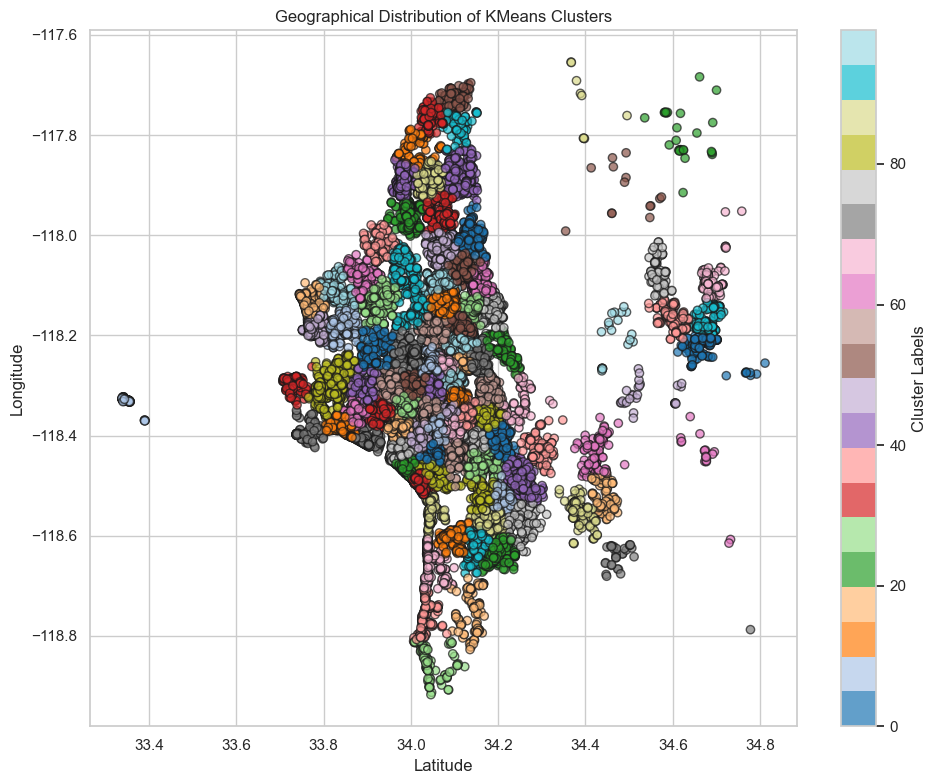

In [195]:
n_clusters = 100

latitude_col = 'latitude'
longitude_col = 'longitude'
coords = data[[latitude_col, longitude_col]]

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(coords)

data['kmeans_group'] = cluster_labels

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    coords[latitude_col], coords[longitude_col], 
    c=cluster_labels, cmap='tab20', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label='Cluster Labels')
plt.title("Geographical Distribution of KMeans Clusters")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.tight_layout()
plt.show()

data_eda = data.copy()
data = data.drop(columns = [longitude_col, latitude_col])

#### Setting up variables

In [ ]:
X = data.drop("price")
y = data["price"]
groups = data["kmeans_group"]

## EDA

#### General Dataset

In [196]:
total_missing_rows = data[data.isnull().any(axis=1)].shape[0]

print(total_missing_rows)

11329


In [197]:
num_rows = data.shape[0]
num_columns = data.shape[1]
column_names = data.columns.tolist()
missing_values = data.isnull().sum()
missing_percentage = (missing_values / num_rows) * 100

# Data dimensions
print('Data dimensions:', data.shape)

# Fraction of missing values per feature
perc_missing_per_ftr = data.isnull().sum(axis=0) / data.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Data types of the features with missing values
print('Data types of the features with missing values:')
print(data[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

# Fraction of points (rows) with missing values
frac_missing = sum(data.isnull().sum(axis=1) != 0) / data.shape[0]
print('Fraction of points with missing values:', frac_missing)

Data dimensions: (36540, 137)
Fraction of missing values in features:
host_response_rate             0.110290
bathrooms                      0.000301
beds                           0.003941
review_scores_rating           0.252490
review_scores_accuracy         0.253612
review_scores_cleanliness      0.253612
review_scores_checkin          0.253722
review_scores_communication    0.253612
review_scores_location         0.253722
review_scores_value            0.253749
first_review                   0.252490
last_review                    0.252490
dtype: float64
Data types of the features with missing values:
host_response_rate             float64
bathrooms                      float64
beds                           float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float

#### Target

In [198]:
# Calculate statistics for the untransformed price
min_price = data_nologprice['price'].min()
max_price = data_nologprice['price'].max()
avg_price = data_nologprice['price'].mean()

# Display the results
print(f"Price ranged from {min_price:.2f} to {max_price:.2f} with an average price of {avg_price:.2f}.")

Price ranged from 6.00 to 99999.00 with an average price of 317.20.


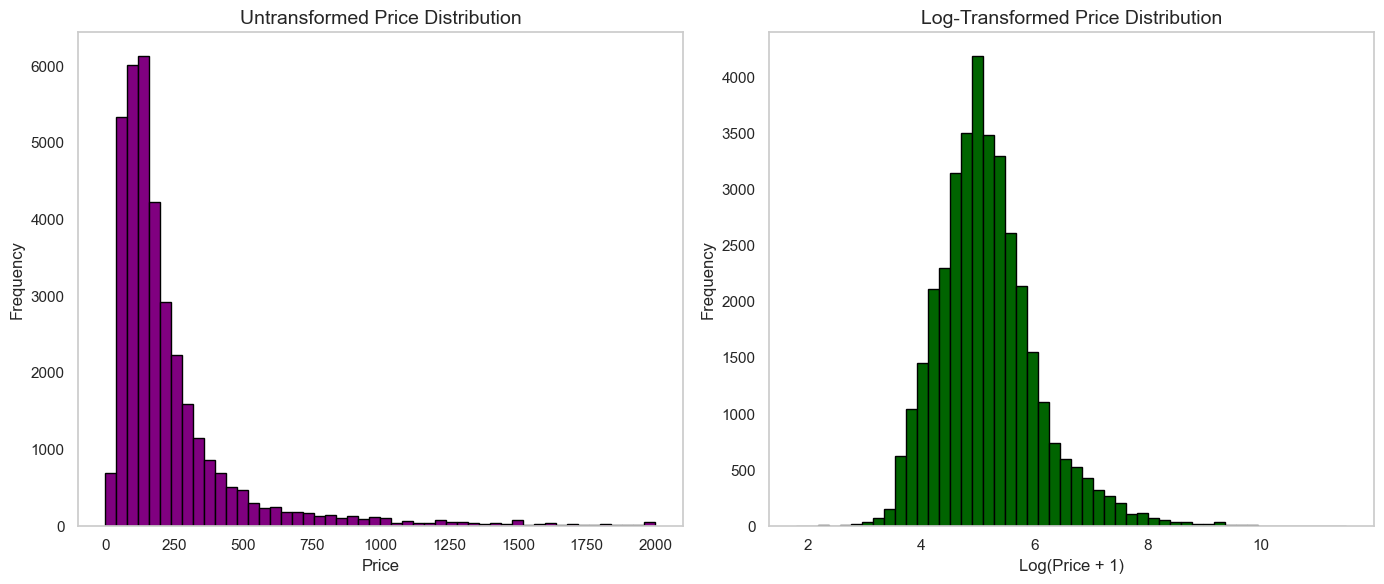

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(data_nologprice["price"], bins=50, color='purple', edgecolor='black', range=(0, 2000))
axes[0].set_title('Untransformed Price Distribution', fontsize=14)
axes[0].set_xlabel('Price', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(False) 

axes[1].hist(data['price'], bins=50, color='darkgreen', edgecolor='black')
axes[1].set_title('Log-Transformed Price Distribution', fontsize=14)
axes[1].set_xlabel('Log(Price + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(False)  

plt.tight_layout()
plt.show()

#### Price Vs Property Characteristics

C:\Users\mdall\AppData\Local\Temp\ipykernel_7252\3644581570.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)


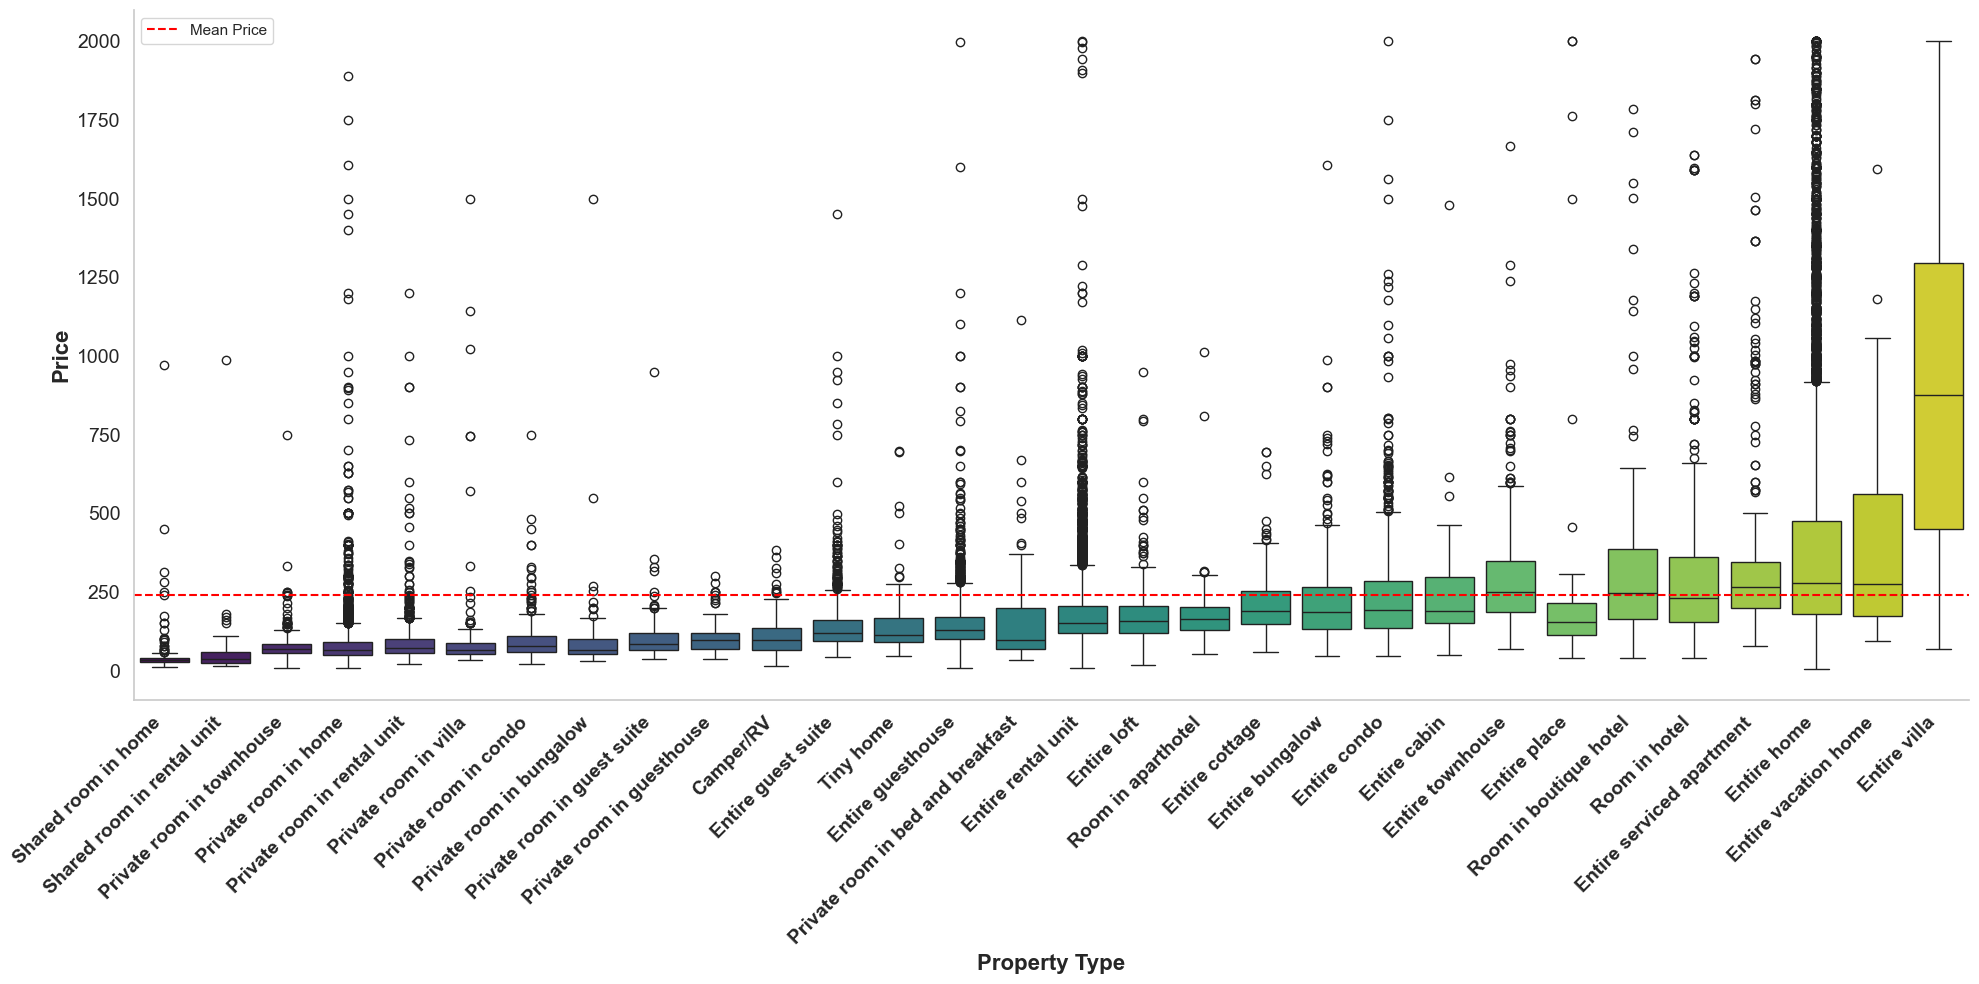

Top 30 Most Common Property Types:
property_type
Entire home                          10513
Entire rental unit                    9325
Private room in home                  4523
Entire guesthouse                     2384
Entire condo                          1458
Private room in rental unit           1209
Entire guest suite                    1110
Entire townhouse                       615
Entire villa                           481
Entire bungalow                        426
Entire serviced apartment              420
Room in hotel                          393
Private room in townhouse              343
Private room in condo                  339
Entire loft                            260
Private room in villa                  220
Shared room in home                    186
Private room in guest suite            169
Room in boutique hotel                 165
Tiny home                              144
Entire cottage                         139
Private room in bed and breakfast      139
Campe

In [200]:
sns.set(style='whitegrid', palette='muted')

# Filter the data for prices between 0 and 2000
filtered_data = data_nologprice[(data_nologprice["price"] >= 0) & (data_nologprice["price"] <= 2000)]

# Get the top 30 most common property types
top_property_types = filtered_data['property_type'].value_counts().nlargest(30).index

# Filter the data to include only the top 30 property types
top_filtered_data = filtered_data[filtered_data['property_type'].isin(top_property_types)]

# Calculate the mean price for each property type in the top 30
mean_prices = top_filtered_data.groupby('property_type')['price'].mean().sort_values()

# Set the size of the figure (increase width for better fitting of labels)
plt.figure(figsize=(20, 10))  # Wider figure for better label visibility

# Create the box plot sorted by mean price
sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)

# Set the title and labels with font size and weight
plt.xlabel('Property Type', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=16, fontweight='bold')

# Remove the outline and grid lines
sns.despine()  # Remove the top and right spines
plt.grid(False)  # Disable the grid

# Adjust x-axis tick labels for better visibility with increased font size
plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold')  # Increased font size and bold font
plt.yticks(fontsize=14)

# Add a horizontal line at the mean price
mean_price = top_filtered_data['price'].mean()  # Mean price for the filtered data
plt.axhline(mean_price, color='red', linestyle='--', label='Mean Price')
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

# Find the most common property types
most_common_property_types = top_filtered_data['property_type'].value_counts().head(30)
print("Top 30 Most Common Property Types:")
print(most_common_property_types)

#### Price Vs Neighbourhood

In [201]:
# Sample DataFrame for demonstration (replace this with your actual data)
# data = pd.read_csv('your_data_file.csv')

# Create a base map centered around LA with a less prominent background
la_location = [34.0522, -118.2437]  # Coordinates for Los Angeles
m = folium.Map(location=la_location, zoom_start=12, tiles='CartoDB positron')  # Using CartoDB positron for a lighter background

# Prepare the data: Filter out rows where price is NaN
filtered_data = data_nologprice.dropna(subset=['price'])

# Sample a subset of data for faster processing (e.g., 10% of the data)
sample_size = int(len(filtered_data) * 0.1)
filtered_data_sample = filtered_data.sample(n=sample_size, random_state=42)

# Define a function to get color based on price ranges
def get_color(price):
    if price < 50:
        return 'green'
    elif 50 <= price < 100:
        return 'lime'
    elif 100 <= price < 150:
        return 'yellow'
    elif 150 <= price < 200:
        return 'orange'
    elif 200 <= price < 250:
        return 'red'
    elif 250 <= price < 300:
        return 'darkred'
    else:
        return 'black'  # For prices 300 and above

# Add CircleMarkers for each listing
for index, row in filtered_data_sample.iterrows():
    # Set a fixed radius
    radius = 7  # You can adjust this value as needed
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,
        color=get_color(row['price']),  # Change color based on price ranges
        fill=True,
        fill_color=get_color(row['price']),
        fill_opacity=0.6,
        popup=f'Price: ${row["price"]}'  # Display price on click
    ).add_to(m)

# Define a function to create a legend
def add_legend(map_object):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; 
                width: 200px; height: auto; 
                z-index: 1000; 
                font-size: 14px; 
                background-color: white; 
                padding: 10px; 
                border: 2px solid grey; 
                border-radius: 5px;">
        <h4 style="text-align: center;">Price Range Legend</h4>
        <i style="background: green; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>< $50<br></span>
        <i style="background: lime; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$50 - $100<br></span>
        <i style="background: yellow; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$100 - $150<br></span>
        <i style="background: orange; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$150 - $200<br></span>
        <i style="background: red; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$200 - $250<br></span>
        <i style="background: darkred; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$250 - $300<br></span>
        <i style="background: black; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span> > $300<br></span>
    </div>
    '''
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m)

m

#### Price Vs Review Sentiment

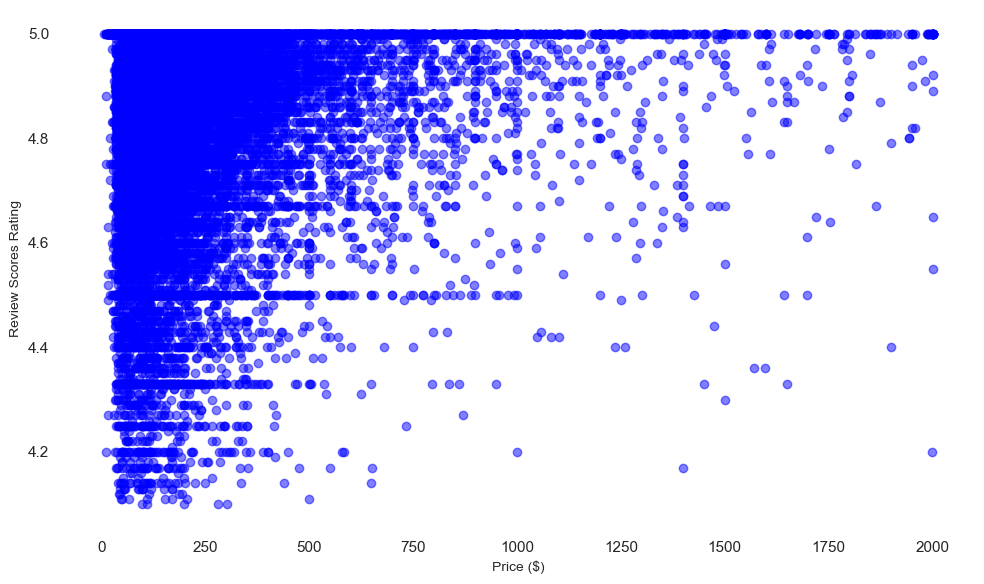

In [202]:
# Filter data for prices between 0 and 2000 and ratings between 4.85 and 5
filtered_data = data_nologprice[(data_nologprice["price"] >= 0) & (data_nologprice["price"] <= 2000) & (data_nologprice['review_scores_rating'] >= 4.1)]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['price'], filtered_data['review_scores_rating'], alpha=0.5, color='blue')

# Set the labels with reduced font size
plt.xlabel('Price ($)', fontsize=10)
plt.ylabel('Review Scores Rating', fontsize=10)

# Remove grid lines, borders, and title for a cleaner look
plt.box(False)  # Remove the border
plt.grid(False)  # Remove grid lines

# Show the plot
plt.tight_layout()
plt.show()

## ML Deployment & Hyperparameter Tuning

#### Defining functions for the ML pipeline

In [18]:
imputer = IterativeImputer(random_state = 42, max_iter = 1)
# imputer = SimpleImputer(strategy='mean')  

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaled_continuous', Pipeline(steps=[
            ('imputer', imputer),
            ('scaler', StandardScaler())
        ]), continuous_features_std),

        ('minmax_scaled_continuous', Pipeline(steps=[
            ('imputer', imputer),
            ('scaler', MinMaxScaler())
        ]), continuous_features_minmax),

        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first')),
        ]), categorical_features),
    ],
    remainder='passthrough',
    verbose=True
)

In [19]:
def train_and_evaluate(X, y, preprocessor, model, param_grid, groups, nr_states):
    """
    Train and evaluate models using GroupShuffleSplit and GroupKFold based on group labels.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.ndarray): Target variable.
        preprocessor (ColumnTransformer): Preprocessing pipeline.
        model (Estimator): Initialized machine learning model.
        param_grid (dict): Parameter grid for GridSearchCV.
        groups (pd.Series or np.ndarray): Group labels for each sample.
        nr_states (int): Number of random states for repeated splits.

    Returns:
        list: List of test R² scores.
        list: List of trained models from GridSearchCV.
        pd.DataFrame: DataFrame containing train and validation R² for each fold.
    """
    test_r2_scores = []
    final_models = []
    all_cv_results = []

    for state in range(nr_states):
        print(f"\nProcessing Random State {state + 1}")

        # Group-aware train-test split using GroupShuffleSplit
        print("Performing group-aware train-test split...")
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42 * state)
        train_idx, test_idx = next(gss.split(X, y, groups=groups))
        X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_groups = groups.iloc[train_idx]

        # Create pipeline with preprocessor and model
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # GridSearchCV with neg_mean_squared_error for scoring but also capturing R²
        print("Starting GridSearchCV with GroupKFold...")
        group_kfold = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(
            pipe,
            param_grid,
            cv=group_kfold.split(X_train_raw, y_train, groups=train_groups),
            scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},  # Specify multiple scorers
            refit='r2',  # Use negative MSE for selecting the best model
            n_jobs=-1,
            verbose=2
        )

        # Fit GridSearchCV
        try:
            grid_search.fit(X_train_raw, y_train)
            print("GridSearchCV completed successfully.")
        except Exception as error:
            print(f"Error during GridSearchCV: {error}")
            raise

        # Extract best model and scores
        best_model = grid_search.best_estimator_
        best_neg_mse = grid_search.best_score_  # Best negative MSE
        best_mse = -best_neg_mse  # Convert to positive MSE
        best_rmse = best_mse ** 0.5  # Convert to RMSE

        # Extract R² scores from cv_results_
        mean_r2_score = np.mean(grid_search.cv_results_['mean_test_r2'])

        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best CV Negative MSE: {best_neg_mse:.4f}")
        print(f"Best CV RMSE: {best_rmse:.4f}")
        print(f"Mean CV R²: {mean_r2_score:.4f}")

        # Test set evaluation
        print("Evaluating best model on the test set...")
        try:
            target_predictions = best_model.predict(X_test_raw)
            test_mse = mean_squared_error(y_test, target_predictions)
            test_rmse = test_mse ** 0.5
            test_r2_score = r2_score(y_test, target_predictions)
        except Exception as error:
            print(f"Error during test set evaluation: {error}")
            raise

        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R²: {test_r2_score:.4f}")

        # Store results
        test_r2_scores.append(test_r2_score)  # Corrected appending the test R² score
        final_models.append(best_model)

        # Save cross-validation results
        results_df = pd.DataFrame(grid_search.cv_results_)
        results_df['random_state'] = state
        all_cv_results.append(results_df)

    # Combine all cross-validation results
    print("Combining all cross-validation results...")
    combined_cv_results = pd.concat(all_cv_results, ignore_index=True)
    print("Model training and evaluation complete.")

    return test_r2_scores, final_models, combined_cv_results


#### Executing the pipeline across ML models

In [426]:
# Dictionary to store final results
results = {}

# Models and reduced hyperparameters
models = {
    'xgboost': (
        XGBRegressor(random_state=42), 
        {
            'model__max_depth': [2, 7, 10],
            'model__learning_rate': [0.2, 0.25, 0.3],
        }
    ),
    'decision_tree': (
        DecisionTreeRegressor(random_state=42),
        {
            'model__max_depth': [5, 6, 7],
            'model__max_features': [320, 330, 340],
        }
    ),
    'random_forest': (
        RandomForestRegressor(random_state=42), 
        { 
            'model__max_depth': [20, 30, 40],
            'model__max_features': [100, 125, 150],
        }
    ),
    'ridge_regression': (
        Ridge(random_state=42),
        {
            'model__alpha': [8, 10, 12],
        }
    ),
}

# Training loop for models
for model_name, (model, param_grid) in models.items():
    print(f"\nTraining {model_name}")
    
    # Train the model using the train_and_evaluate function
    test_r2_scores, final_models, _ = train_and_evaluate(
        X=X,
        preprocessor=preprocessor, 
        y=y,
        model=model,
        param_grid=param_grid,
        groups=groups,
        nr_states=5, 
    )
    
    # Calculate mean and std of R²
    mean_r2 = np.mean(test_r2_scores)
    std_r2 = np.std(test_r2_scores)

    # Store results
    results[model_name] = {
        'mean_r2': mean_r2,
        'std_r2': std_r2,
        'test_r2_scores': test_r2_scores,
        'models': final_models
    }

    print(f"{model_name} Results:")
    print(f"Mean R²: {mean_r2:.4f}")
    print(f"Std R²: {std_r2:.4f}")

print("\nModel Performance Summary:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Mean R²: {result['mean_r2']:.4f}")
    print(f"  Std R²: {result['std_r2']:.4f}")

best_model_name = max(results, key=lambda x: results[x]['mean_r2'])
best_model = results[best_model_name]['models']

print("\nBest Model:", best_model_name)
print(f"Mean R²: {results[best_model_name]['mean_r2']:.4f}")
print(f"Std R²: {results[best_model_name]['std_r2']:.4f}")


Training xgboost

Processing Random State 1
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7}
Best CV Negative MSE: 0.7341
Best CV RMSE: nan
Mean CV R²: 0.7199
Evaluating best model on the test set...
Test RMSE: 0.4283
Test R²: 0.7298

Processing Random State 2
Performing group-aware train-test split...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7}
Best CV Negative MSE: 0.7448
Best CV RMSE: nan
Mean CV R²: 0.7289
Evaluating best model on the test set...
Test RMSE: 0.4471
Test R²: 0.7139

Processing Random State 3
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7}
Best CV Negative MSE: 0.7473
Best CV RMSE: nan
Mean CV R²: 0.7327
Evaluating best model on the test set...
Test RMSE: 0.4568
Test R²: 0.7093

Processing Random State 4
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 10}
Best CV Negative MSE: 0.7281
Best CV RMSE: nan
Mean CV R²: 0.7170
Evaluating best model on the test set...
Test RMSE: 0.4348
Test R²: 0.7786

Processing Random State 5
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__learning_rate': 0.25, 'model__max_depth': 7}
Best CV Negative MSE: 0.7392
Best CV RMSE: nan
Mean CV R²: 0.7249
Evaluating best model on the test set...
Test RMSE: 0.4091
Test R²: 0.7531
Combining all cross-validation results...
Model training and evaluation complete.
xgboost Results:
Mean R²: 0.7369
Std R²: 0.0259

Training decision_tree

Processing Random State 1
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 7, 'model__max_features': 340}
Best CV Negative MSE: 0.6040
Best CV RMSE: nan
Mean CV R²: 0.5880
Evaluating best model on the test set...
Test RMSE: 0.5155
Test R²: 0.6086

Processing Random State 2
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 7, 'model__max_features': 340}
Best CV Negative MSE: 0.6161
Best CV RMSE: nan
Mean CV R²: 0.5972
Evaluating best model on the test set...
Test RMSE: 0.5591
Test R²: 0.5525

Processing Random State 3
Performing group-aware train-test split...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 7, 'model__max_features': 330}
Best CV Negative MSE: 0.6213
Best CV RMSE: nan
Mean CV R²: 0.6055
Evaluating best model on the test set...
Test RMSE: 0.5300
Test R²: 0.6087

Processing Random State 4
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 7, 'model__max_features': 330}
Best CV Negative MSE: 0.6153
Best CV RMSE: nan
Mean CV R²: 0.6019
Evaluating best model on the test set...
Test RMSE: 0.5508
Test R²: 0.6447


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE



Processing Random State 5
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 7, 'model__max_features': 320}
Best CV Negative MSE: 0.6149
Best CV RMSE: nan
Mean CV R²: 0.6033
Evaluating best model on the test set...
Test RMSE: 0.5255
Test R²: 0.5925
Combining all cross-validation results...
Model training and evaluation complete.
decision_tree Results:
Mean R²: 0.6014
Std R²: 0.0298

Training random_forest

Processing Random State 1
Performing group-aware train-test split...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 30, 'model__max_features': 100}
Best CV Negative MSE: 0.7194
Best CV RMSE: nan
Mean CV R²: 0.7170
Evaluating best model on the test set...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Test RMSE: 0.4373
Test R²: 0.7184

Processing Random State 2
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.6s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 30, 'model__max_features': 100}
Best CV Negative MSE: 0.7308
Best CV RMSE: nan
Mean CV R²: 0.7290
Evaluating best model on the test set...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Test RMSE: 0.4685
Test R²: 0.6858

Processing Random State 3
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.5s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 30, 'model__max_features': 125}
Best CV Negative MSE: 0.7273
Best CV RMSE: nan
Mean CV R²: 0.7256
Evaluating best model on the test set...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Test RMSE: 0.4483
Test R²: 0.7201

Processing Random State 4
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 30, 'model__max_features': 100}
Best CV Negative MSE: 0.7201
Best CV RMSE: nan
Mean CV R²: 0.7182
Evaluating best model on the test set...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Test RMSE: 0.4574
Test R²: 0.7551

Processing Random State 5
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__max_depth': 40, 'model__max_features': 150}
Best CV Negative MSE: 0.7305
Best CV RMSE: nan
Mean CV R²: 0.7288
Evaluating best model on the test set...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Test RMSE: 0.4331
Test R²: 0.7232
Combining all cross-validation results...
Model training and evaluation complete.
random_forest Results:
Mean R²: 0.7205
Std R²: 0.0219

Training ridge_regression

Processing Random State 1
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__alpha': 10}
Best CV Negative MSE: 0.6891
Best CV RMSE: nan
Mean CV R²: 0.6886
Evaluating best model on the test set...
Test RMSE: 0.4970
Test R²: 0.6362

Processing Random State 2
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__alpha': 8}
Best CV Negative MSE: 0.6805
Best CV RMSE: nan
Mean CV R²: 0.6804
Evaluating best model on the test set...
Test RMSE: 0.4822
Test R²: 0.6671

Processing Random State 3
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__alpha': 8}
Best CV Negative MSE: 0.7073
Best CV RMSE: nan
Mean CV R²: 0.7067
Evaluating best model on the test set...
Test RMSE: 0.5217
Test R²: 0.6209

Processing Random State 4
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.0s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.3s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__alpha': 12}
Best CV Negative MSE: 0.6805
Best CV RMSE: nan
Mean CV R²: 0.6798
Evaluating best model on the test set...
Test RMSE: 0.4747
Test R²: 0.7361

Processing Random State 5
Performing group-aware train-test split...
Starting GridSearchCV with GroupKFold...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE
c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.4s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
GridSearchCV completed successfully.
Best Parameters: {'model__alpha': 12}
Best CV Negative MSE: 0.6713
Best CV RMSE: nan
Mean CV R²: 0.6707
Evaluating best model on the test set...
Test RMSE: 0.4488
Test R²: 0.7028
Combining all cross-validation results...
Model training and evaluation complete.
ridge_regression Results:
Mean R²: 0.6726
Std R²: 0.0424

Model Performance Summary:
xgboost:
  Mean R²: 0.7369
  Std R²: 0.0259
decision_tree:
  Mean R²: 0.6014
  Std R²: 0.0298
random_forest:
  Mean R²: 0.7205
  Std R²: 0.0219
ridge_regression:
  Mean R²: 0.6726
  Std R²: 0.0424

Best Model: xgboost
Mean R²: 0.7369
Std R²: 0.0259


C:\Users\mdall\AppData\Local\Temp\ipykernel_21840\2323258755.py:65: RuntimeWarning: invalid value encountered in scalar power
  best_rmse = best_mse ** 0.5  # Convert to RMSE


## Results

#### Baseline Vs Predicted Accuracy

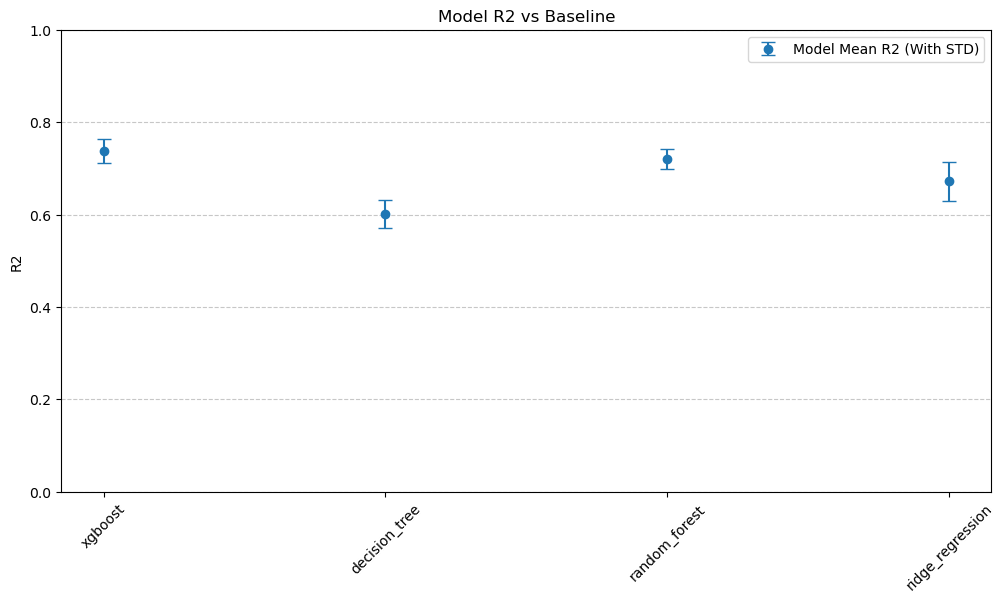

In [427]:
model_names = list(results.keys())
mean_r2 = [results[model]['mean_r2'] for model in model_names]
std_r2 = [results[model]['std_r2'] for model in model_names]

plt.figure(figsize=(12, 6))
x_positions = np.arange(len(model_names))

plt.errorbar(
    x_positions,
    mean_r2,
    yerr=std_r2,
    fmt='o',
    capsize=5,
    label='Model Mean R2 (With STD)'
)

# Customize the plot
plt.xticks(x_positions, model_names, rotation=45)
plt.ylabel("R2")
plt.title("Model R2 vs Baseline")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.00)

# Show the plot
plt.show()

#### Global Feature Importance

In [206]:
# Split the data using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]

# Create a pipeline with preprocessor and model
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(max_depth=7, learning_rate = 0.2, random_state=42))  # Use provided max_depth parameter
])

# Train the pipeline
pipe.fit(X_train_raw, y_train)

# Evaluate the model on the test set
y_pred = pipe.predict(X_test_raw)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.5s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
Test RMSE: 0.4471
Test R²: 0.7139


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


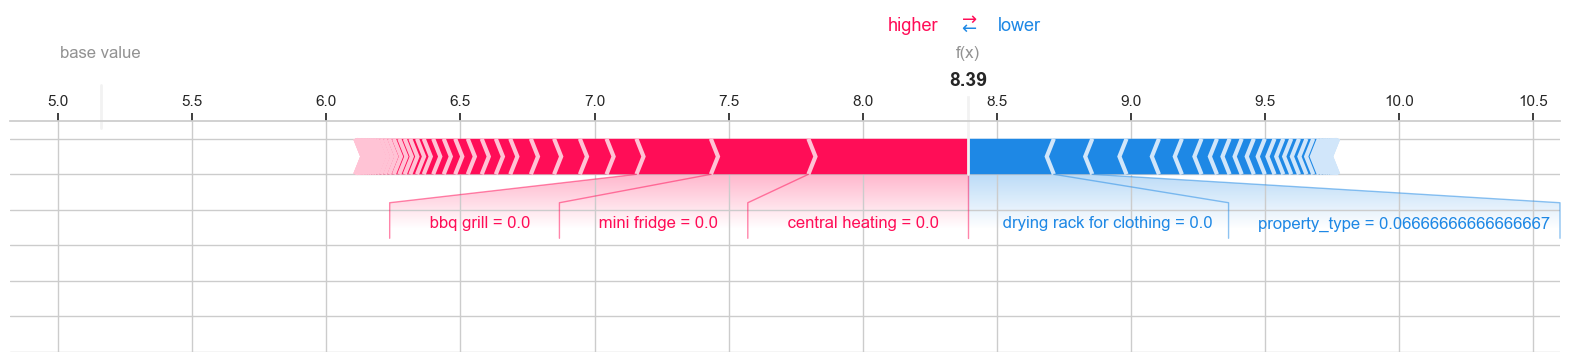

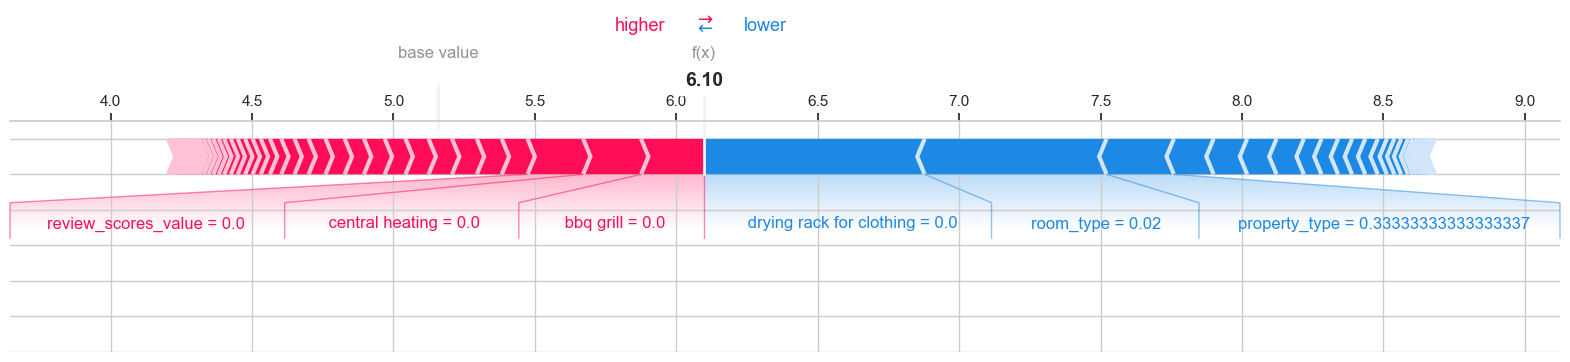

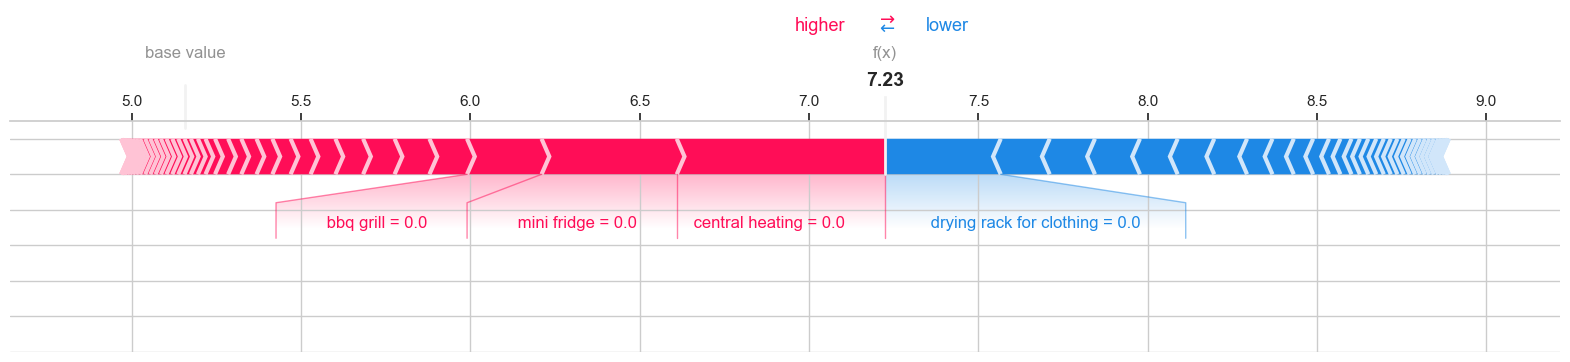

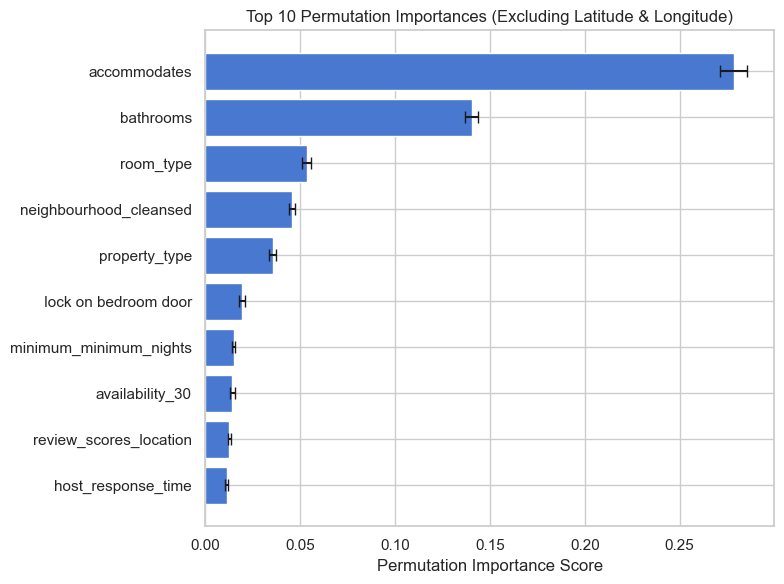

                       feature  importance_mean  importance_std
6                 accommodates         0.278349        0.007064
7                    bathrooms         0.140337        0.003330
5                    room_type         0.053400        0.002366
3       neighbourhood_cleansed         0.045731        0.001828
4                property_type         0.035520        0.002012
..                         ...              ...             ...
41    free parking on premises        -0.000182        0.000126
65                   body soap        -0.000217        0.000237
83                      keypad        -0.000246        0.000234
37                     shampoo        -0.000254        0.000121
133               first_review        -0.001909        0.000824

[135 rows x 3 columns]


In [207]:
# Calculate permutation importance
perm_importance = permutation_importance(
    pipe,
    X_test_raw,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

# Organize feature importance results
importance_results = pd.DataFrame({
    "feature": X_test_raw.columns,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
}).sort_values(by="importance_mean", ascending=False)

filtered_features = importance_results[~importance_results['feature'].isin(['longitude', 'latitude'])]

# Select the top 10 features after filtering
top_features = filtered_features.head(10)

# Plot the permutation importances
plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'], top_features['importance_mean'], xerr=top_features['importance_std'], capsize=4)
plt.title("Top 10 Permutation Importances (Excluding Latitude & Longitude)")
plt.xlabel("Permutation Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display feature importance results
print(importance_results)

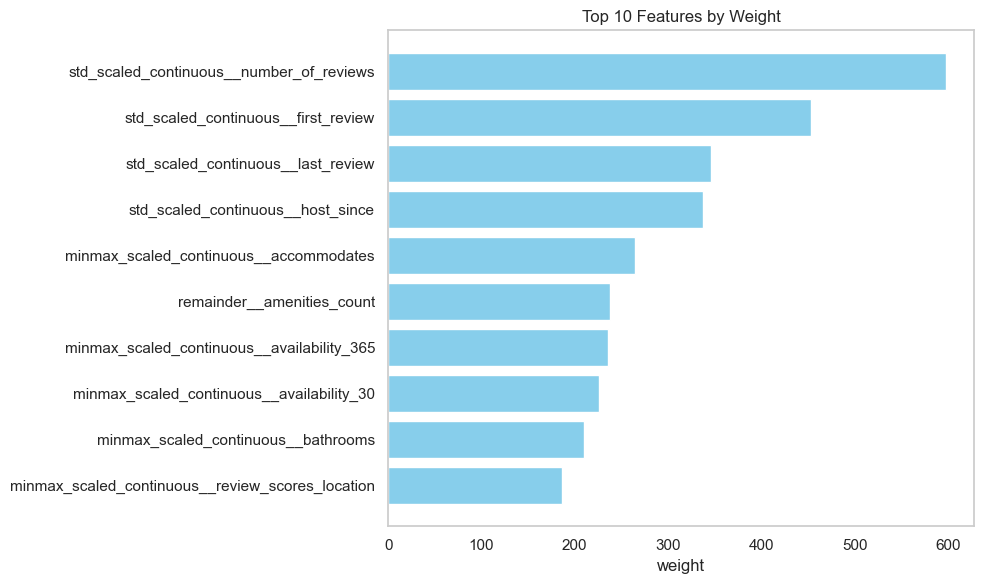

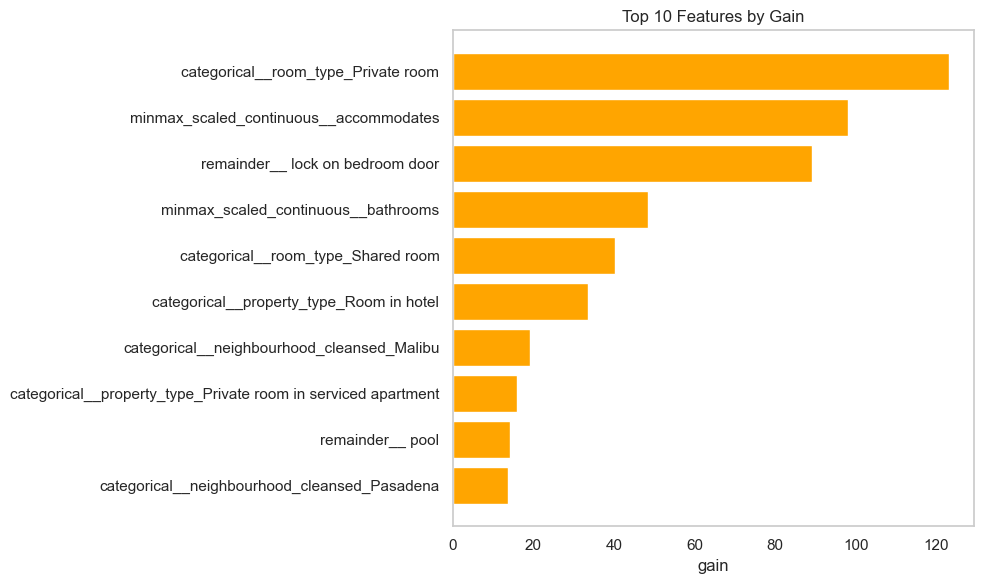

In [208]:
importance_metrics = ['weight', 'gain']

xgb_model = pipe.named_steps['model']

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()

importance = {
    metric: xgb_model.get_booster().get_score(importance_type=metric) for metric in importance_metrics
}

data = []
for metric, values in importance.items():
    for f, value in values.items():
        data.append({'Feature': feature_names[int(f[1:])], 'Metric': metric, 'Value': value})

feature_importance_df = pd.DataFrame(data)

def plot_top_features(df, metric, color):
    top_features = df[df['Metric'] == metric].sort_values(by='Value', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'][::-1], top_features['Value'][::-1], align='center', color=color)
    plt.xlabel(metric)
    plt.title(f'Top 10 Features by {metric.capitalize()}')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

colors = ['skyblue', 'orange', 'green', 'purple', 'red']  
for metric, color in zip(importance_metrics, colors):
    plot_top_features(feature_importance_df, metric=metric, color=color)


#### Predicted Vs Actual Values Scatter Plot

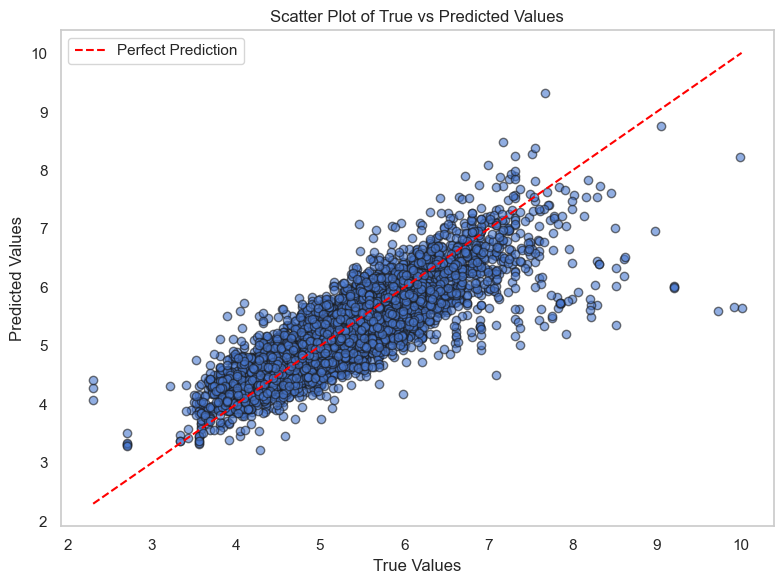

In [209]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Scatter Plot of True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

#### Local Feature Importance

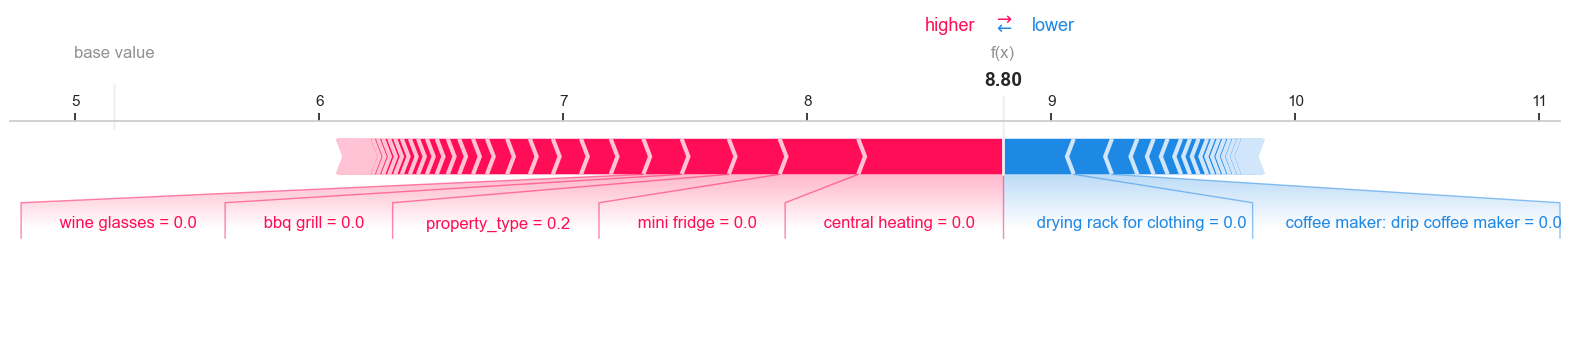

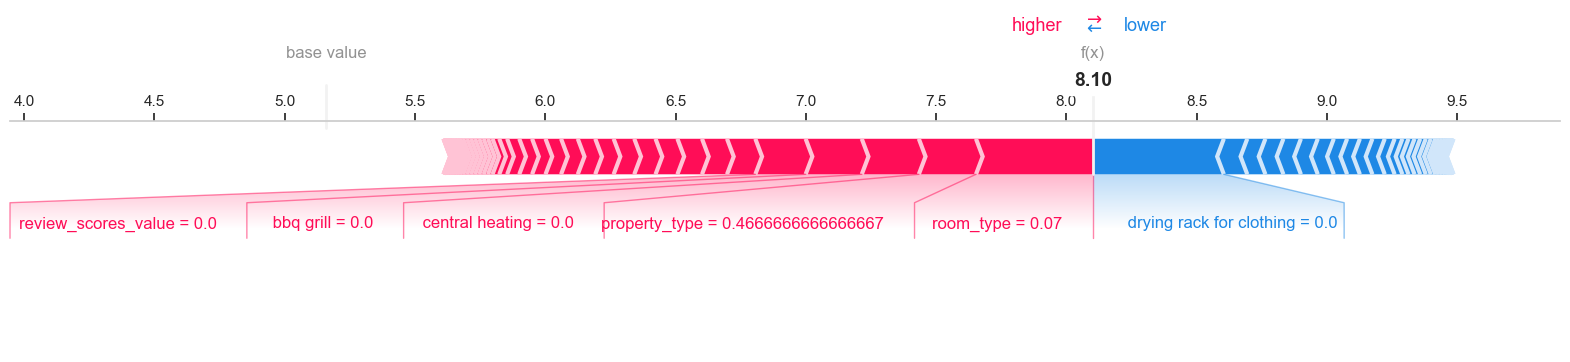

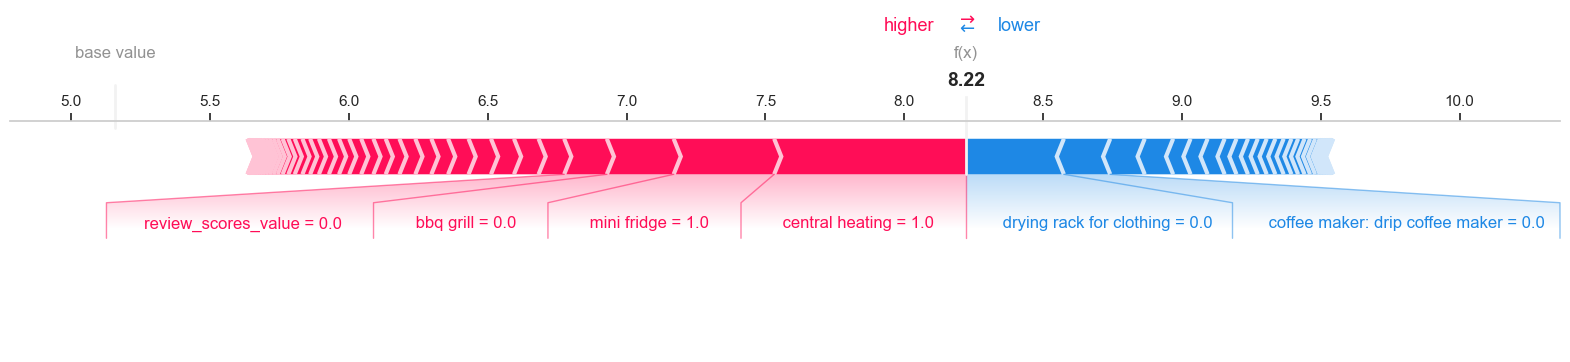

In [210]:
np.set_printoptions(precision=6)

shap.initjs()

np.set_printoptions(precision=6)

explainer = shap.TreeExplainer(pipe.named_steps['model'])

X_test_transformed = pipe.named_steps['preprocessor'].transform(X_test_raw)

if hasattr(X_test_transformed, 'toarray'):
    X_test_transformed = X_test_transformed.toarray()

shap_values = explainer.shap_values(X_test_transformed)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

random_indices = np.random.choice(len(X_test_raw), 3, replace=False)

for idx in random_indices:
    
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        features=X_test_transformed[idx],
        feature_names=X_test_raw.columns, 
        show = False, 
        matplotlib = True
    )

    force_plot.gca().grid(False)
    display(force_plot)